In [21]:
import os

models_to_test = []
datasets_for_models = []

# FAD, NADH, SHG
* ResNet18
* InceptionResNetV2
* Xception

In [22]:
from my_modules.nsclc import NSCLCDataset
from my_modules.custom_models import CometClassifierWithBinaryOutput, FeatureExtractorToClassifier, ResNet18NPlaned
from pretrainedmodels import inceptionresnetv2, xception
from torch import nn
import torch

data = NSCLCDataset('D:/Paola/JI-Finalized NSCLC Dataset Oct 2024',
                    ['fad', 'nadh', 'shg'],
                    device=torch.device('cpu'),
                    label='Metastases',
                    mask_on=True,
                    remove_empties=False)
data.augment()
data.normalize_method = 'preset'
root_dir = r'C:\Users\jdivers\Desktop\Results\fad-nadh-shg'

models = []
# ResNet18
model = ResNet18NPlaned(data.shape, start_width=64, n_classes=1)
model.load_state_dict(
    torch.load(root_dir + r'\Resnet18\Epochs 1500 3-Planed ResNet18.pth', map_location=torch.device('cpu'))
)
models.append(model)


# InceptionResNetV2 Feature Extractor (BigCoMET)
feature_extractor = inceptionresnetv2(num_classes=1000, pretrained=False)
classifier = CometClassifierWithBinaryOutput
model = FeatureExtractorToClassifier(data.shape,
                                           feature_extractor=feature_extractor,
                                           classifier=classifier, layer='conv2d_7b')
model.load_state_dict(
    torch.load(root_dir + r'\InceptionResNetV2\Epochs 1500 InceptionResNetV2 Features to type Classifier.pth',
map_location=torch.device('cpu')))
models.append(model)

# Xception Feature Extractor
feature_extractor = xception(num_classes=1000, pretrained=False)
classifier = nn.Sequential(nn.Linear(2048, 1), nn.Sigmoid())
model = FeatureExtractorToClassifier(data.shape,
                                           feature_extractor=feature_extractor,
                                           classifier=classifier, layer='conv4')
model.load_state_dict(
    torch.load(root_dir + r'\Xception\Epochs 1500 Xception Features to Sequential Classifier.pth',
map_location=torch.device('cpu')))
models.append(model)

for model in models:
    models_to_test.append(model)
    datasets_for_models.append(data)

Cache opened.


C:\Users\jdivers\PycharmProjects\NSCLC_Classification\my_modules\custom_models\classifier_models.py:562: RuntimeWarning: 
<class 'RuntimeError'> error caught during ordered layer search
Given input size: (1536x6x6). Calculated output size: (1536x0x0). Output size is too small
  warnings.warn(f'\n{type(e)} error caught during ordered layer search\n{e}', RuntimeWarning)
C:\Users\jdivers\PycharmProjects\NSCLC_Classification\my_modules\custom_models\classifier_models.py:679: RuntimeWarning: 
<class 'RuntimeError'> error caught during feature extraction
Given input size: (1536x6x6). Calculated output size: (1536x0x0). Output size is too small
  warnings.warn(f'\n{type(e)} error caught during feature extraction\n{e}', RuntimeWarning)


# FAD, NADH, SHG, ORR
* ResNet18
* InceptionResNetV2

In [23]:
from my_modules.nsclc import NSCLCDataset
import torch
from my_modules.custom_models import AdaptedInputInceptionResNetV2

data = NSCLCDataset('D:/Paola/JI-Finalized NSCLC Dataset Oct 2024',
                    ['fad', 'nadh', 'shg', 'orr'],
                    device=torch.device('cpu'),
                    label='Metastases',
                    mask_on=True,
                    remove_empties=False)
data.augment()
data.normalize_method = 'preset'
root_dir = r'C:\Users\jdivers\Desktop\Results\fad-nadh-shg-orr'

# ResNet18
models = []
model = ResNet18NPlaned(data.shape, start_width=64, n_classes=1)
model.load_state_dict(
    torch.load(root_dir + r'\Resnet18\Epochs 250 4-Planed ResNet18.pth', map_location=torch.device('cpu'))
)
models.append(model)

# InceptionResNetV2 Feature Extractor (BigCoMET)
feature_extractor = AdaptedInputInceptionResNetV2(data.shape, num_classes=1000, pretrained=False)
classifier = CometClassifierWithBinaryOutput
model = FeatureExtractorToClassifier(data.shape,
                                           feature_extractor=feature_extractor,
                                           classifier=classifier, layer='inceptionresnetv2.conv2d_7b')
model.load_state_dict(
    torch.load(root_dir + r'\InceptionResNetV2\Epochs 500 AdaptedInputInceptionResNetV2 Features to type Classifier.pth',
map_location=torch.device('cpu')))
models.append(model)


for model in models:
    models_to_test.append(model)
    datasets_for_models.append(data)

Cache opened.


C:\Users\jdivers\PycharmProjects\NSCLC_Classification\my_modules\custom_models\classifier_models.py:562: RuntimeWarning: 
<class 'RuntimeError'> error caught during ordered layer search
Given input size: (1536x6x6). Calculated output size: (1536x0x0). Output size is too small
  warnings.warn(f'\n{type(e)} error caught during ordered layer search\n{e}', RuntimeWarning)
C:\Users\jdivers\PycharmProjects\NSCLC_Classification\my_modules\custom_models\classifier_models.py:679: RuntimeWarning: 
<class 'RuntimeError'> error caught during feature extraction
Given input size: (1536x6x6). Calculated output size: (1536x0x0). Output size is too small
  warnings.warn(f'\n{type(e)} error caught during feature extraction\n{e}', RuntimeWarning)


# NADH, ORR
* ResNet18
* Xception
* CNN

In [24]:
from my_modules.nsclc import NSCLCDataset
import torch
from my_modules.custom_models import AdaptedInputXception, CNNet, ResNet18NPlaned, FeatureExtractorToClassifier

data = NSCLCDataset('D:/Paola/JI-Finalized NSCLC Dataset Oct 2024',
                    ['nadh', 'orr'],
                    device=torch.device('cpu'),
                    label='Metastases',
                    mask_on=True,
                    remove_empties=False)
data.augment()
data.normalize_method = 'preset'
root_dir = r'C:\Users\jdivers\Desktop\Results\nadh-orr'

# ResNet18
models = []
model = ResNet18NPlaned(data.shape, start_width=64, n_classes=1)
model.load_state_dict(
    torch.load(root_dir + r'\Resnet18\Epochs 2500 2-Planed ResNet18.pth', map_location=torch.device('cpu'))
)
models.append(model)


feature_extractor = AdaptedInputXception(data.shape, num_classes=1000, pretrained=False)
classifier = torch.nn.Sequential(torch.nn.Linear(2048, 1), torch.nn.Sigmoid())
model = FeatureExtractorToClassifier(data.shape,
                                           feature_extractor=feature_extractor,
                                           classifier=classifier, layer='xception.conv4')
model.load_state_dict(
    torch.load(root_dir + r'\Xception\Epochs 250 AdaptedInputXception Features to Sequential Classifier.pth',
               map_location=torch.device('cpu')))

models.append(model)

model = CNNet(data.shape)
model.load_state_dict(torch.load(root_dir + r'\CNN\Epochs 2500 CN Net.pth', map_location=torch.device('cpu')))
models.append(model)

for model in models:
    models_to_test.append(model)
    datasets_for_models.append(data)

Cache opened.


# SHG, ORR, Intensity
* CNN

In [25]:
from my_modules.nsclc import NSCLCDataset
from my_modules.custom_models import CNNet
import torch

data = NSCLCDataset('D:/Paola/JI-Finalized NSCLC Dataset Oct 2024',
                    ['shg', 'orr', 'intensity'],
                    device=torch.device('cpu'),
                    label='Metastases',
                    mask_on=True,
                    remove_empties=False)
data.augment()
data.normalize_method = 'preset'
root_dir = r'C:\Users\jdivers\Desktop\Results\shg-orr-intensity'

# ResNet18
model = CNNet(data.shape)
model.load_state_dict(torch.load(root_dir + r'\CNN\Epochs 1500 CN Net.pth', map_location=torch.device('cpu')))
models_to_test.append(model)
datasets_for_models.append(data)



Cache opened.


# SHG
* ResNet18
* InceptionResNetV2
* Xception

In [26]:
from my_modules.nsclc import NSCLCDataset
from my_modules.custom_models import CometClassifierWithBinaryOutput, FeatureExtractorToClassifier, ResNet18NPlaned
from pretrainedmodels import inceptionresnetv2, xception
import torch

data = NSCLCDataset('D:/Paola/JI-Finalized NSCLC Dataset Oct 2024',
                    ['shg'],
                    device=torch.device('cpu'),
                    label='Metastases',
                    mask_on=True,
                    remove_empties=False)
data.augment()
data.normalize_method = 'preset'
root_dir = r'C:\Users\jdivers\Desktop\Results\shg'

# ResNet18
models = []
model = ResNet18NPlaned(data.shape, start_width=64, n_classes=1)
model.load_state_dict(
    torch.load(root_dir + r'\Resnet18\Epochs 500 1-Planed ResNet18.pth', map_location=torch.device('cpu'))
)
model.name = model.name + 'Trained to 500 Epochs'
models.append(model)

model = ResNet18NPlaned(data.shape, start_width=64, n_classes=1)
model.load_state_dict(
    torch.load(root_dir + r'\Resnet18\Epochs 2500 1-Planed ResNet18.pth', map_location=torch.device('cpu'))
)
model.name = model.name + 'Trained to 2500 Epochs'
models.append(model)



# InceptionResNetV2 Feature Extractor (BigCoMET)
feature_extractor = inceptionresnetv2(num_classes=1000, pretrained=False)
classifier = CometClassifierWithBinaryOutput
model = FeatureExtractorToClassifier(data.shape,
                                           feature_extractor=feature_extractor,
                                           classifier=classifier, layer='conv2d_7b')
model.load_state_dict(
    torch.load(root_dir + r'\InceptionResNetV2\/Epochs 500 InceptionResNetV2 Features to type Classifier.pth', map_location=torch.device('cpu'))
)
models.append(model)

# Xception Feature Extractor
feature_extractor = xception(num_classes=1000, pretrained=False)
classifier = torch.nn.Sequential(torch.nn.Linear(2048, 1), torch.nn.Sigmoid())
model = FeatureExtractorToClassifier(data.shape,
                                           feature_extractor=feature_extractor,
                                           classifier=classifier, layer='conv4')
model.load_state_dict(
    torch.load(root_dir + r'\Xception\Epochs 1500 Xception Features to Sequential Classifier.pth', map_location=torch.device('cpu')))
models.append(model)

for model in models:
    models_to_test.append(model)
    datasets_for_models.append(data)

Cache opened.


C:\Users\jdivers\PycharmProjects\NSCLC_Classification\my_modules\custom_models\classifier_models.py:562: RuntimeWarning: 
<class 'RuntimeError'> error caught during ordered layer search
Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 1, 256, 256] to have 3 channels, but got 1 channels instead
  warnings.warn(f'\n{type(e)} error caught during ordered layer search\n{e}', RuntimeWarning)
C:\Users\jdivers\PycharmProjects\NSCLC_Classification\my_modules\custom_models\classifier_models.py:591: RuntimeWarning: 
Input channels 1 does not match default feature extractor input.
Input will be expanded to 3 channels to match.
  warnings.warn(f'\nInput channels {self.input_size[0]} does not match default feature extractor input.'
C:\Users\jdivers\PycharmProjects\NSCLC_Classification\my_modules\custom_models\classifier_models.py:679: RuntimeWarning: 
<class 'RuntimeError'> error caught during feature extraction
Given input size: (1536x6x6). Calculated output size: (1536x0x0). Output 

In [27]:
from IPython.display import display, Markdown
test_pt = [0, 3, 6, 12, 18, 19, 25, 29]
pt_id = [data.get_patient_ID(pt) for pt in test_pt]
pt_idx = [data.get_patient_subset(pt) for pt in test_pt]
pt_lab = [data.get_patient_label(pt).item() for pt in test_pt]
n_img = [len(pt) for pt in pt_idx]
md_table = '# Breakdown of testing patients\n'
md_table += '| ID | Index | # of FOV Images | Class |\n'
md_table += '|:--:|:-----:|:---------------:|:-----:|\n'
for pt, idx, n, lab in zip(pt_id, test_pt, n_img, pt_lab):
    md_table += f'|**{pt}**|{idx}|{n//5}|{'Metastatic' if not lab else 'Non-Metastatic'}|\n'
display(Markdown(md_table))

# Breakdown of testing patients
| ID | Index | # of FOV Images | Class |
|:--:|:-----:|:---------------:|:-----:|
|**S0014**|0|6|Metastatic|
|**V0027**|3|6|Metastatic|
|**V0142**|6|5|Non-Metastatic|
|**S0241**|12|6|Non-Metastatic|
|**S0031**|18|6|Metastatic|
|**S0093**|19|6|Non-Metastatic|
|**V0198**|25|8|Non-Metastatic|
|**W0137**|29|6|Metastatic|


nsclc_Metastases_fad+nadh+shg_Augmented_NormalizedTo-preset_Masked 3-Planed ResNet18


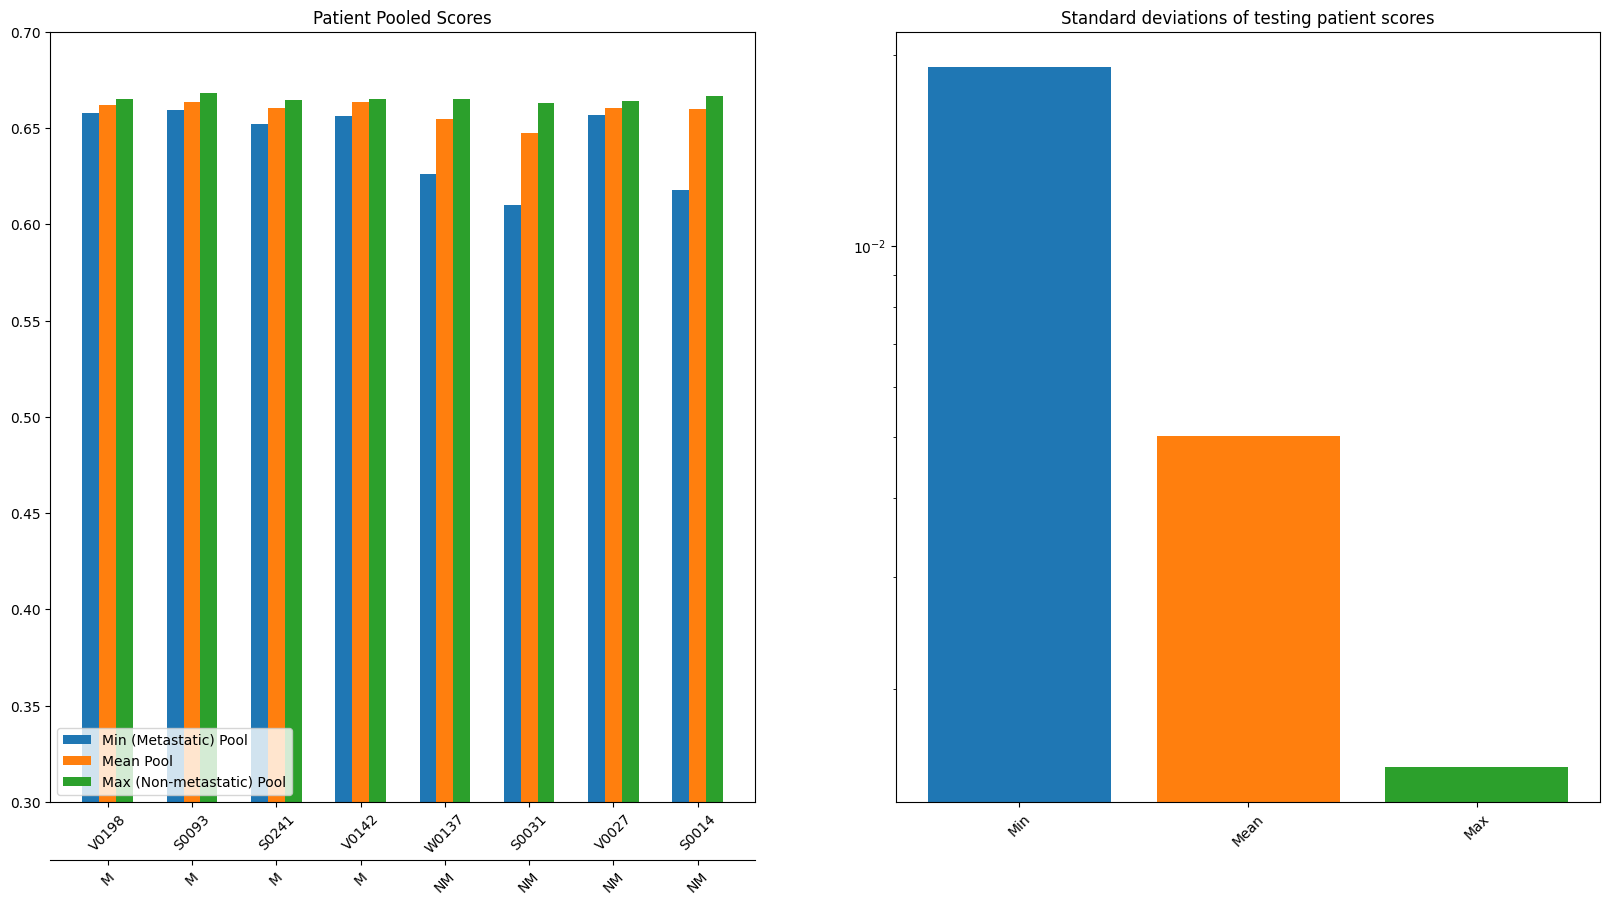

nsclc_Metastases_fad+nadh+shg_Augmented_NormalizedTo-preset_Masked InceptionResNetV2 Features to type Classifier



KeyboardInterrupt



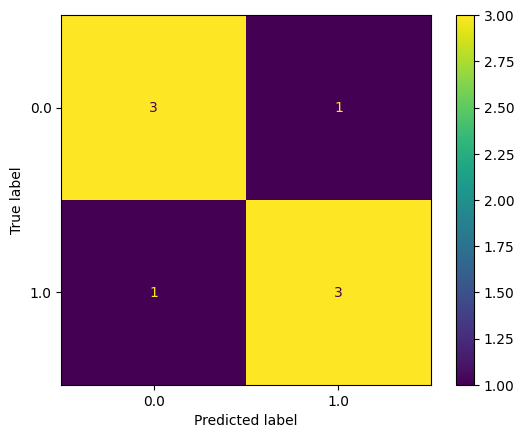

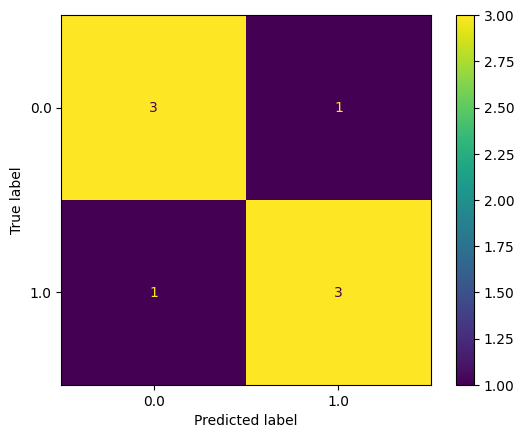

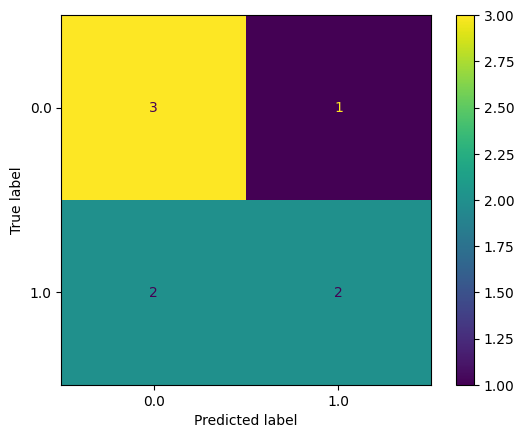

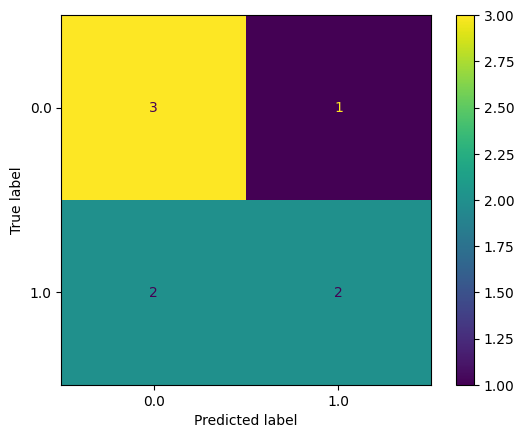

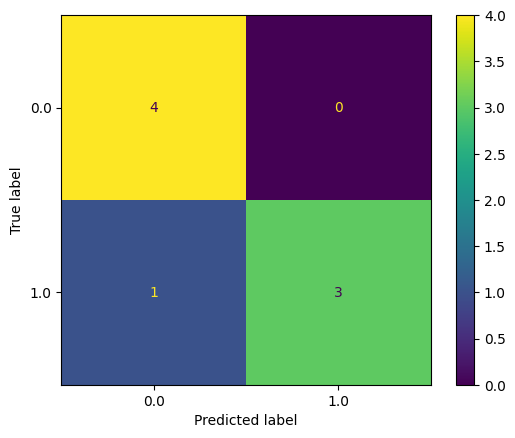

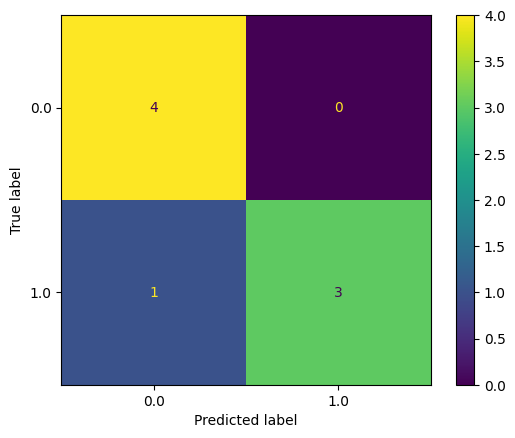

In [15]:
for model, data in zip(models_to_test, datasets_for_models):
    print(data.name, model.name)
    pt_outs = []
    model.eval()
    with torch.no_grad():
        for i, indices in enumerate(pt_idx):
            out = [model(torch.unsqueeze(data[idx][0], 0)).item() for idx in indices]
            pt_outs.append(out)
    import numpy as np
    max_pool_out = [max(out) for out in pt_outs]
    min_pool_out = [min(out) for out in pt_outs]
    mean_out = [np.mean(out) for out in pt_outs]
    import matplotlib.pyplot as plt

    # Sort indices
    sort_idx = np.argsort(pt_lab)
    sorted_ids = np.asarray(pt_id)[sort_idx[::-1]]

    # Convert data to NumPy arrays
    max_vals = np.asarray(max_pool_out)[sort_idx[::-1]]
    min_vals = np.asarray(min_pool_out)[sort_idx[::-1]]
    mean_vals = np.asarray(mean_out)[sort_idx[::-1]]

    # Define bar width and offsets
    width = 0.2
    x = np.arange(len(sorted_ids))  # Use integer positions for x-axis

    # Create grouped bar plot
    os.makedirs(f'figures/{data.name}/{model.name}', exist_ok=True)
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].bar(x - width, min_vals, width=width, label='Min (Metastatic) Pool')
    ax[0].bar(x, mean_vals, width=width, label='Mean Pool')
    ax[0].bar(x + width, max_vals, width=width, label='Max (Non-metastatic) Pool')
    ax[0].set_title('Patient Pooled Scores')
    ax[0].set_ylim([0.3, 0.7])


    # Set x-axis labels to patient IDs
    ax[0].set_xticks(ticks=x, labels=sorted_ids, rotation=45)

    # Add secondary x-axis for NM/M labels
    lab_ax = ax[0].secondary_xaxis(-0.075)
    lab_ax.set_ticks(ticks=x, labels=['NM' if pt_lab[idx] else 'M' for idx in sort_idx], rotation=45)

    # Add legend and show plot
    ax[0].legend(loc='lower left')

    x = np.arange(3)
    ax[1].bar(0, np.std(min_pool_out), label='Min (Metastatic) Pool')
    ax[1].bar(1, np.std(mean_out), label='Mean Pool')
    ax[1].bar(2, np.std(max_pool_out), label='Max (Non-metastatic) Pool')
    ax[1].set_xticks(ticks=x, labels=('Min', 'Mean', 'Max'), rotation=45)
    ax[1].set_title('Standard deviations of testing patient scores')
    ax[1].set_yscale('log')
    fig.savefig(f'figures/{data.name}/{model.name}/pt_pool_minmaxmean_stdev.png')
    plt.show()
    plt.close(fig)


    from sklearn.metrics import roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, \
        precision_recall_curve, average_precision_score, f1_score, fbeta_score
    from matplotlib.lines import Line2D
    import pandas as pd

    for outs, method in zip([min_pool_out, max_pool_out, mean_out], ['Min (Metastatic) pooling', 'Max (Non-metastatic) pooling', 'Mean']):
        fig, ax = plt.subplots(2, 3, figsize=(20, 10))
        fig.suptitle(f'Using {method}', fontsize=20)

        fpr, tpr, thresholds = roc_curve(pt_lab, outs)
        roc_auc = auc(fpr, tpr)
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax[0,0])
        ax[0,0].set_title(f'Receiver operating characteristic')
        ax[0,0].set_ylim([0, 1])

        roc_table = pd.DataFrame(data={'Threshold': thresholds, 'FPR': fpr, 'TPR': tpr})
        roc_table.to_csv(f'roc_{method}.csv', index=False)

        opt_thresh = thresholds[np.argmax(tpr - fpr)]
        preds = [out > opt_thresh for out in outs]
        ConfusionMatrixDisplay.from_predictions(pt_lab, preds).plot(ax=ax[1,0])
        ax[1,0].set_title('Confusion Matrix at Youden\'s J')

        precision, recall, thresholds = precision_recall_curve(pt_lab, outs)
        ap = average_precision_score(pt_lab, outs)
        PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax[0,1])
        pr_auc = auc(recall, precision)
        # ax[2].text(0.7, 0.025, , transform=ax[2].transAxes)
        line = Line2D([0], [0], label=f'AP = {np.nanmax(ap):0.2f}\nAUC = {pr_auc:0.2f}')
        handles = [line]
        ax[0,1].legend(handles=handles, loc='lower right')
        ax[0,1].set_title('Precision Recall Curve')
        ax[0,1].set_ylim([0, 1])

        ax[1,1].axis('off')

        thresholds = np.append(thresholds, float('inf'))
        f1 = 2 * (precision * recall) / (precision + recall)
        opt_thresh = thresholds[np.argmax(f1)]
        ax[0,2].plot(thresholds, f1, label=f'Max F1 Score = {np.nanmax(f1):0.2f}')
        ax[0,2].set_title('F1 Score by Threshold')
        ax[0,2].legend(loc='lower right')
        ax[0,2].set_ylim([0, 1])

        ConfusionMatrixDisplay.from_predictions(pt_lab, preds).plot(ax=ax[1,2])
        ax[1,2].set_title('Confusion Matrix at maximum F1 score')

        pr_table = pd.DataFrame(data={'Threshold': thresholds, 'Precision': precision, 'Recall': recall, 'F1 Score': f1})
        pr_table.to_csv(f'prf_{method}.csv', index=False)

        fig.savefig(f'figures/{data.name}/{model.name}/roc_precrec_f1_confmats_{method}.png')
        plt.close(fig)

# Comparing models
The goal is ultimately to find which model(s) differentiate between metastatic and non-metastatic patients best. To determine this, we will find the min and max of each patient, then find the average of the mins and maxes for all patients from each class. For example, we will have average minimum for non-metastatic patients for ResNet18 trainined on FAD-NADH-ORR and average minimum for metastatic patients for ResNet18 trainined on FAD-NADH-ORR. Then we will take the difference of these two values to determine on average how well does the minimum value from a ResNet18 trained on FAD-NADH-ORR differentiate between metastatic and non-metastatic patients. We will repeat for the maximum and for all datasets and all models.

In [28]:
import numpy as np
max_diff = []
min_diff = []
d_names = []
m_names = []
for model, data in zip(models_to_test, datasets_for_models):
    d_names.append(data.name.split('_')[2])
    m_names.append(model.name)

    pt_outs = []
    model.eval()
    with torch.no_grad():
        for i, indices in enumerate(pt_idx):
            out = [model(torch.unsqueeze(data[idx][0], 0)).item() for idx in indices]
            pt_outs.append(out)

    max_pool_out = np.asarray([max(out) for out in pt_outs])
    min_pool_out = np.asarray([min(out) for out in pt_outs])
    pt_lab = np.asarray(pt_lab)

    max_m = np.mean(max_pool_out[np.where(pt_lab == 0)])
    max_nm = np.mean(max_pool_out[np.where(pt_lab == 1)])
    max_diff.append(np.abs(max_m - max_nm))

    min_m = np.mean(min_pool_out[np.where(pt_lab == 0)])
    min_nm = np.mean(min_pool_out[np.where(pt_lab == 1)])
    min_diff.append(np.abs(min_m - min_nm))


In [31]:
sub_labels =list(dict.fromkeys(d_names))
print(sub_labels)

['fad+nadh+shg', 'fad+nadh+shg+orr', 'nadh+orr', 'shg+orr+intensity', 'shg']


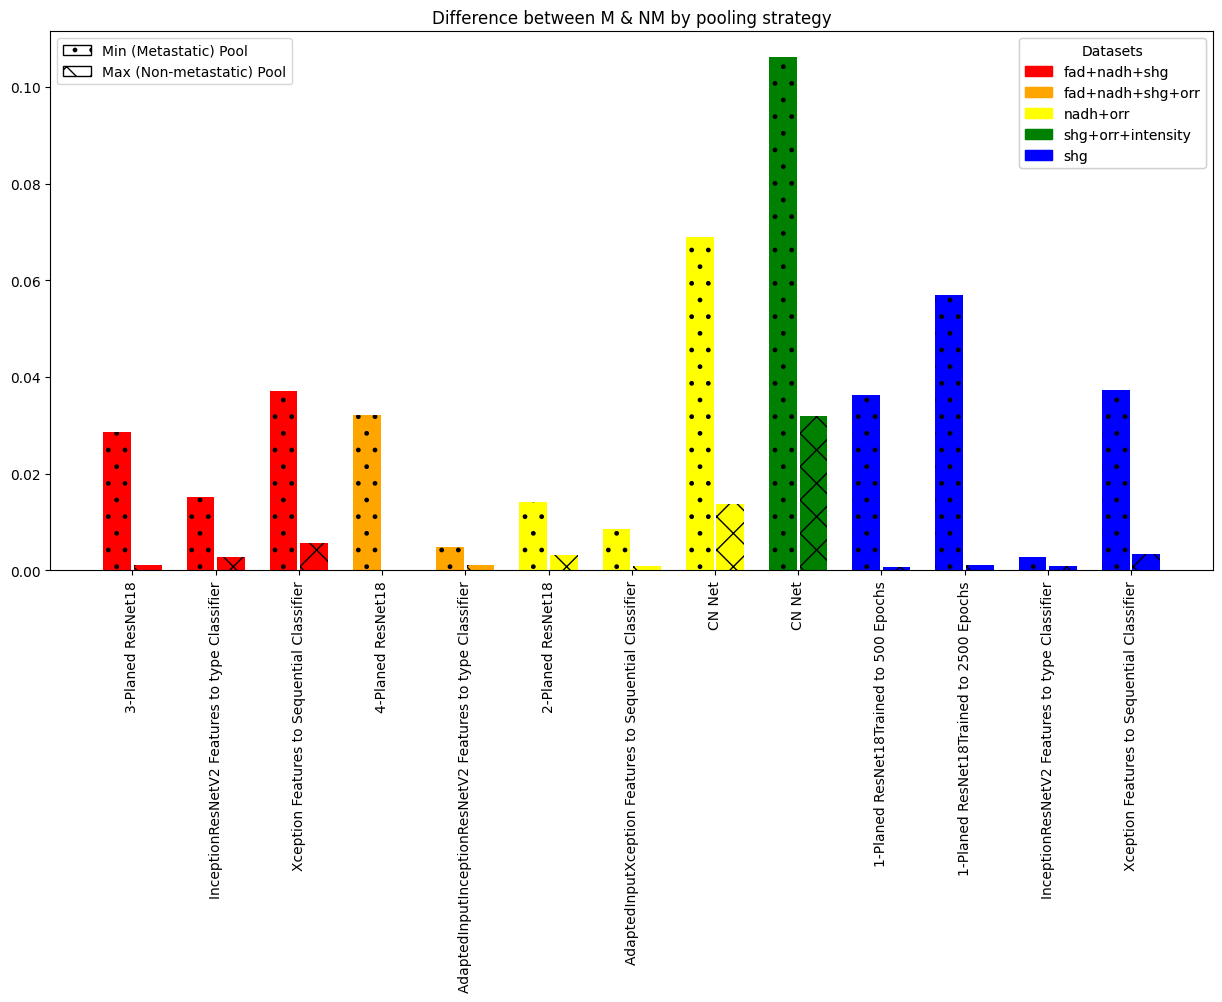

In [32]:
# Define bar width and offsets
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

width = 5
x = 3 * width * np.arange(len(models_to_test))  # Use integer positions for x-axis

dataset_colors = {sub_labels[0]: 'red',
                  sub_labels[1]: 'orange',
                  sub_labels[2]: 'yellow',
                  sub_labels[3]: 'green',
                  sub_labels[4]: 'blue'}
short = []
for name in m_names:
    match name.lower():
        case 'resnet18':
            short.append('ResNet18')
        case 'inception':
            short.append('InceptionResNetV2')
        case 'xception':
            short.append('Xception')
        case _:
            short.append(name)
m_names = short

# Create grouped bar plot
os.makedirs(f'figures/model_compare/', exist_ok=True)
fig, ax = plt.subplots(figsize=(15, 7))
for i, (d, m) in enumerate(zip(d_names, m_names)):
    c = dataset_colors[d]
    ax.bar(x[i] - 0.55 * width, min_diff[i], width=width, color=c, hatch='.', label='_nolegend_')
    ax.bar(x[i] + 0.55 * width, max_diff[i], width=width, color=c, hatch='x', label='_nolegend_')
ax.set_title('Difference between M & NM by pooling strategy')

# Set x-axis labels to patient IDs
ax.set_xticks(ticks=x)
ax.set_xticklabels(labels=m_names, rotation=90)

# Add primary legend for Min/Max pooling
legend1_patches = [
    mpatches.Patch(facecolor='white', edgecolor='black', hatch='.', label='Min (Metastatic) Pool'),
    mpatches.Patch(facecolor='white', edgecolor='black', hatch='x', label='Max (Non-metastatic) Pool')
]
legend1 = ax.legend(handles=legend1_patches, loc='upper left')


# Create secondary legend for datasets
dataset_patches = [mpatches.Patch(color=dataset_colors[d], label=d) for d in sub_labels]
legend2 = ax.legend(handles=dataset_patches, loc='upper right', title='Datasets')
ax.add_artist(legend1)  # Keep both legends visible
ax.add_artist(legend2)

plt.show()


In [ ]:
import glob


def plot_training(root_dir):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    pth = glob.glob(os.path.join(root_dir, "*.pth"))
    if len(pth) > 1:
        raise RuntimeError

    table = pd.read_csv(f'{root_dir}/tabular.csv')
    ep = pth[0].split('Epochs ')[1]
    ep = int(ep.split(' ')[0])
    ax1.plot(table['Epoch'][0:ep], table['Training Loss (average per sample)'][0:ep], label='Training Loss')
    ax1.plot(table['Epoch'][0:ep], table['Evaluation Loss (average per sample)'][0:ep], label='Evaluation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Evaluation Losses')
    ax1.legend()

    ax2.plot(table['Epoch'][0:ep], table['Training ROC-AUC'][0:ep], label='Training ROC-AUC')
    ax2.plot(table['Epoch'][0:ep], table['Evaluation ROC-AUC'][0:ep], label='Evaluation ROC-AUC')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('AUC')
    ax2.set_title('Training and Evaluation ROC-AUC')
    ax2.legend()

    fig.savefig(f'{root_dir}/training plots.png')
    plt.close(fig)

In [ ]:
root_dir = r'C:\Users\jdivers\Desktop\Results\shg-orr-intensity\cnn'
plot_training(root_dir)



In [ ]:
from my_modules.nsclc import NSCLCDataset
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as t

def plot_data(data, index):
    fig, ax = plt.subplots(1, data.stack_height, figsize=(15, 3))
    stack = data[index][0]
    for jj in range(data.stack_height):
        img = t.ToPILImage()(stack[jj])
        ax[jj].imshow(img, cmap='gray')
        ax[jj].set_title(f'{data.mode[jj].upper()}', fontsize=10)
        ax[jj].tick_params(top=False, bottom=False, left=False, right=False,
               labelleft=False, labelbottom=False)
        slide_idx, *_ = data.__parse_index__(index)
        fig.suptitle(f'{data.features['ID']['Subject'].iloc[slide_idx]}, {'Non-' if data[index][1] == 1 else ''}Metastatic',
                 fontsize=14)
    return fig

In [ ]:
data = NSCLCDataset('D:/Paola/JI-Finalized NSCLC Dataset Oct 2024',
                    ['fad', 'nadh', 'shg', 'orr', 'intensity'],
                    label='Metastases',
                    mask_on=False,
                    remove_empties=False)

index = np.random.randint(0, len(data))

In [ ]:
fig = plot_data(data, index)
plt.show()
fig.savefig(f'figures/sample_images/raw_img_{index}.png')
plt.close(fig)

data.mask_on = True
fig = plot_data(data, index)
plt.show()
fig.savefig(f'figures/sample_images/masked_raw_img_{index}.png')
plt.close(fig)

data.augment()
index *= 5
fig = plot_data(data, index)
plt.show()
fig.savefig(f'figures/sample_images/masked_augmented_raw_img_{index}_pt_{index / 5}.png')
plt.close(fig)

data.normalize_method = 'preset'
fig = plot_data(data, index)
plt.show()
fig.savefig(f'figures/sample_images/masked_augmented_normalized_img_{index}_pt_{index / 5}.png')

data.transforms = t.Compose([t.RandomVerticalFlip(p=0.25),
                                         t.RandomHorizontalFlip(p=0.25),
                                         t.RandomRotation(degrees=(-180, 180))])
fig = plot_data(data, index)
plt.show()
fig.savefig(f'figures/sample_images/transformed_masked_augmented_normalized_img_{index}pt_{index / 5}.png')
plt.close(fig)